Fitting a Mixture Model with Gibbs Sampling

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy import stats
from collections import namedtuple, Counter

We are going to work with data of Galaxy expasion velocities, a numeric vector of velocities in km/sec of 82 galaxies from 6 well-separated conic sections of an unfilled survey of the Corona Borealis region. Multimodality in such surveys is evidence for voids and superclusters in the far universe. 

In [2]:
data = np.loadtxt('https://raw.githubusercontent.com/LeobardoEnriquezH/Data/main/galaxy.txt', delimiter=',', skiprows=1, dtype=str)
data = pd.to_numeric(data)
data = pd.DataFrame(data=data)

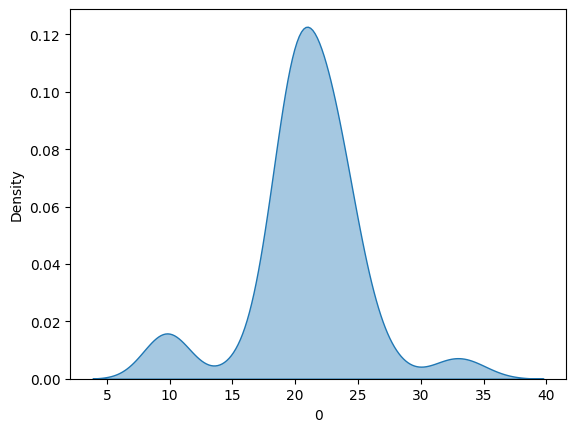

In [3]:
#https://python-graph-gallery.com/density-chart-multiple-groups-seaborn/
sns.kdeplot(data=data, x=data[0],  fill=True, common_norm=False, alpha=0.4)
plt.show()

In [4]:
SuffStat = namedtuple('SuffStat', 'theta N')

def update_suffstats(state):
    for cluster_id, N in Counter(state['assignment']).items():
        points_in_cluster = [x 
            for x, cid in zip(state['data_'], state['assignment'])
            if cid == cluster_id
        ]
        mean = np.array(points_in_cluster).mean()
        
        state['suffstats'][cluster_id] = SuffStat(mean, N)

def initial_state():
    num_clusters = 3
    alpha = 1.0
    cluster_ids = range(num_clusters)

    state = {
        'cluster_ids_': cluster_ids,
        'data_': data,
        'num_clusters_': num_clusters,
        'cluster_variance_': .01,
        'alpha_': alpha,
        'hyperparameters_': {
            "mean": 0,
            "variance": 1,
        },
        'suffstats': [None, None, None],
        'assignment': [random.choice(cluster_ids) for _ in data],
        'pi': [alpha / num_clusters for _ in cluster_ids],
        'cluster_means': [-1, 0, 1]
    }
    update_suffstats(state)
    return state

state = initial_state()

In [5]:
for k, v in state.items():
    print(k)

cluster_ids_
data_
num_clusters_
cluster_variance_
alpha_
hyperparameters_
suffstats
assignment
pi
cluster_means


In [6]:
# Gibbs Sampling
# Conditional Distribution of Assignment
def log_assignment_score(data_id, cluster_id, state):
    """log p(z_i=k \,|\, \cdot) 
    
    We compute these scores in log space for numerical stability.
    """
    x = state['data_'][data_id]
    theta = state['cluster_means'][cluster_id]
    var = state['cluster_variance_']
    log_pi = np.log(state['pi'][cluster_id])
    return log_pi + stats.norm.logpdf(x, theta, var)


def assigment_probs(data_id, state):
    """p(z_i=cid \,|\, \cdot) for cid in cluster_ids
    """
    scores = [log_assignment_score(data_id, cid, state) for cid in state['cluster_ids_']]
    scores = np.exp(np.array(scores))
    return scores / scores.sum()


def sample_assignment(data_id, state):
    """Sample cluster assignment for data_id given current state
    
    cf Step 1 of Algorithm 2.1 in Sudderth 2006
    """
    p = assigment_probs(data_id, state)
    return np.random.choice(state['cluster_ids_'], p=p)


def update_assignment(state):
    """Update cluster assignment for each data point given current state 
    
    cf Step 1 of Algorithm 2.1 in Sudderth 2006
    """
    for data_id, x in enumerate(state['data_']):
        state['assignment'][data_id] = sample_assignment(data_id, state)
    update_suffstats(state)


In [7]:
# Conditional Distribution of Mixture Weights
def sample_mixture_weights(state):
    """Sample new mixture weights from current state according to 
    a Dirichlet distribution 
    
    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    ss = state['suffstats']
    alpha = [ss[cid].N + state['alpha_'] / state['num_clusters_'] 
             for cid in state['cluster_ids_']]
    return stats.dirichlet(alpha).rvs(size=1).flatten()

def update_mixture_weights(state):
    """Update state with new mixture weights from current state
    sampled according to a Dirichlet distribution 
    
    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    state['pi'] = sample_mixture_weights(state)

In [8]:
#Conditional Distribution of Cluster Means
def sample_cluster_mean(cluster_id, state):
    cluster_var = state['cluster_variance_']
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    ss = state['suffstats'][cluster_id]
    
    numerator = hp_mean / hp_var + ss.theta * ss.N / cluster_var
    denominator = (1.0 / hp_var + ss.N / cluster_var)
    posterior_mu = numerator / denominator
    posterior_var = 1.0 / denominator
    
    return stats.norm(posterior_mu, np.sqrt(posterior_var)).rvs()


def update_cluster_means(state):
    state['cluster_means'] = [sample_cluster_mean(cid, state)
                              for cid in state['cluster_ids_']]

In [9]:
#Doing each of these three updates in sequence makes a complete Gibbs step for our mixture model. Here is a function to do that:
def gibbs_step(state):
    update_assignment(state)
    update_mixture_weights(state)
    update_cluster_means(state)

In [10]:
# Initially, we assigned each data point to a random cluster. We can see this by plotting a histogram of each cluster.
def plot_clusters(state):
    gby = pd.DataFrame({
            'data': state['data_'], 
            'assignment': state['assignment']}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.5 )
    
plot_clusters(state)

ValueError: Data must be 1-dimensional